# False Positive Brand Classifier - Model Evaluation & Deployment

This notebook performs final test set evaluation, threshold optimization, and exports the trained classifier for deployment.

## Objective
Evaluate the best model from fp2 on the held-out test set, optimize the classification threshold for target recall, and export artifacts for deployment.

**Important:** This is the ONLY notebook that uses the test set. All model selection and tuning was performed in fp2 using cross-validation.

## Contents
1. [Setup](#setup)
2. [Data Loading & Split](#1-data-loading--split)
3. [Load Artifacts from fp1/fp2](#2-load-artifacts-from-fp1fp2)
4. [Test Set Evaluation](#3-test-set-evaluation)
5. [Threshold Optimization](#4-threshold-optimization)
6. [Export for Deployment](#5-export-for-deployment)
7. [Pipeline Validation](#6-pipeline-validation)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sklearn imports
from sklearn.metrics import fbeta_score

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import load_jsonl_data, split_train_val_test
from src.fp1_nb.preprocessing import clean_text, create_text_features
from src.fp1_nb.modeling import evaluate_model
from src.fp3_nb.threshold_optimization import (
    find_optimal_threshold,
    analyze_threshold_tradeoffs,
    plot_threshold_analysis,
)
from src.fp3_nb.deployment import (
    create_deployment_pipeline,
    save_deployment_artifacts,
    validate_pipeline,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TARGET_COL = 'is_sportswear'
TARGET_RECALL = 0.98  # Target recall for threshold optimization

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

print("Setup complete!")

Setup complete!


## 1. Data Loading & Split

Load data and apply identical preprocessing and split as fp1/fp2 to ensure consistency.

In [2]:
# Load the FP training data (same as fp1/fp2)
df = load_jsonl_data(DATA_PATH)

# Create combined text features (identical to fp1/fp2)
# Includes metadata (source_name, category) for consistency
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print(f"\nText features created!")

Loaded 1,005 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 7.26 MB



Text features created!


In [3]:
# Split with stratification (identical to fp1/fp2 - same random_state ensures identical splits)
train_df, val_df, test_df = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=RANDOM_STATE
)

# Extract metadata for discrete metadata features (same as fp1/fp2)
test_source_names = test_df['source_name'].tolist()
test_categories = test_df['category'].tolist()

TRAIN/VALIDATION/TEST SPLIT

Total samples: 1,005

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      603 (60.0%)
  Validation: 201 (20.0%)
  Test:       201 (20.0%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 85.9%, 0: 14.1%
  Val: 1: 85.6%, 0: 14.4%
  Test: 1: 86.1%, 0: 13.9%


## 2. Load Artifacts from fp1/fp2

Load the feature transformer from fp1 and the best classifier from fp2.

In [4]:
# Load feature transformer from fp1
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
transformer = joblib.load(transformer_path)
print(f"Loaded transformer: {transformer}")

# Load best classifier from fp2
classifier_path = MODELS_DIR / 'fp_best_classifier.joblib'
best_model = joblib.load(classifier_path)
print(f"Loaded classifier: {type(best_model).__name__}")

# Load CV metrics from fp2
cv_metrics_path = MODELS_DIR / 'fp_cv_metrics.json'
with open(cv_metrics_path) as f:
    cv_metrics = json.load(f)

print(f"\nCV Metrics (from fp2):")
print(f"  Model: {cv_metrics['model_name']}")
print(f"  CV F2: {cv_metrics['cv_f2']:.4f}")
print(f"  CV Recall: {cv_metrics['cv_recall']:.4f}")
print(f"  CV Precision: {cv_metrics['cv_precision']:.4f}")

Loaded transformer: FPFeatureTransformer(method='sentence_transformer_ner', max_features=10000, fitted=True)
Loaded classifier: RandomForestClassifier

CV Metrics (from fp2):
  Model: RF_tuned
  CV F2: 0.9723
  CV Recall: 0.9957
  CV Precision: 0.8888


In [5]:
# Transform test set using the fitted transformer
# Pass metadata for discrete metadata features (consistent with fp1/fp2)
X_test = transformer.transform(
    test_df['text_features'],
    source_names=test_source_names,
    categories=test_categories
)
y_test = test_df[TARGET_COL].values

print(f"X_test shape: {X_test.shape}")
print(f"y_test distribution: {pd.Series(y_test).value_counts().to_dict()}")

X_test shape: (201, 398)
y_test distribution: {1: 173, 0: 28}


## 3. Test Set Evaluation

Evaluate the best model on the held-out test set (used only once, here).


MODEL EVALUATION: RF_tuned on Test

Classification Metrics:
  Accuracy:  0.8905
  Precision: 0.8995
  Recall:    0.9827
  F1 Score:  0.9392
  ROC-AUC:   0.9643
  PR-AUC:    0.9945

Confusion Matrix:
  TN: 9  FP: 19
  FN: 3  TP: 170

                precision    recall  f1-score   support

Not Sportswear       0.75      0.32      0.45        28
    Sportswear       0.90      0.98      0.94       173

      accuracy                           0.89       201
     macro avg       0.82      0.65      0.69       201
  weighted avg       0.88      0.89      0.87       201



Figure saved to images/fp_test_evaluation.png


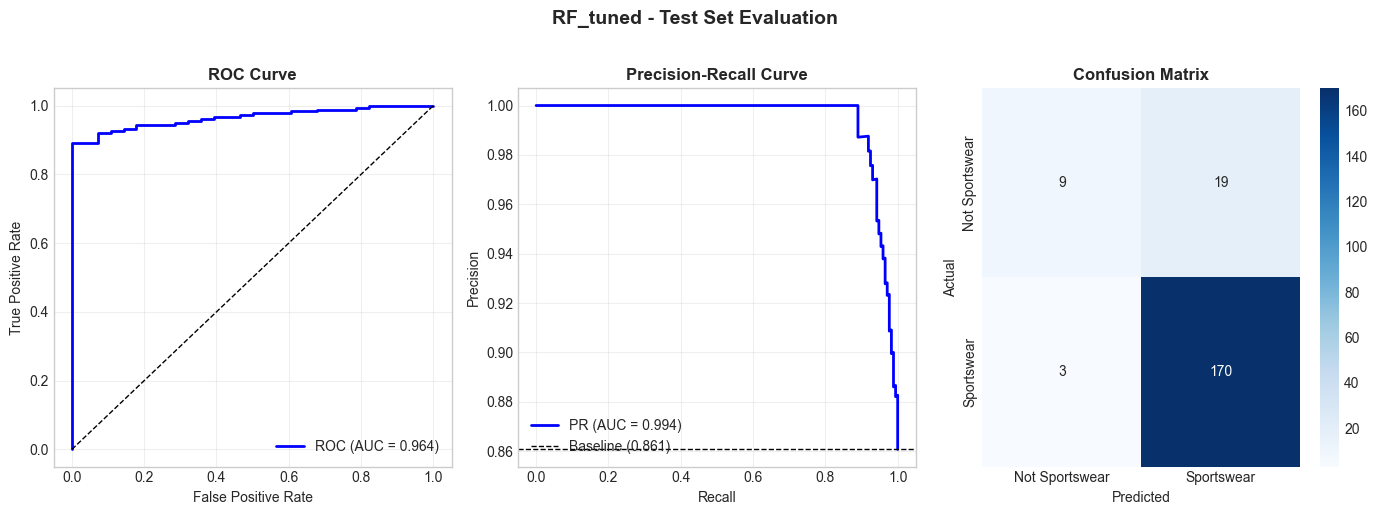

  F2 Score:  0.9648 (recall-weighted)


In [6]:
# Evaluate on held-out test set
test_metrics = evaluate_model(
    best_model, X_test, y_test,
    model_name=cv_metrics['model_name'],
    dataset_name='Test',
    verbose=True,
    plot=True,
    save_path='images/fp_test_evaluation.png'
)

# Add F2 score
y_pred_test = best_model.predict(X_test)
test_metrics['f2'] = fbeta_score(y_test, y_pred_test, beta=2)
print(f"  F2 Score:  {test_metrics['f2']:.4f} (recall-weighted)")

In [7]:
# Compare CV vs Test performance (generalization check)
print("=" * 60)
print("GENERALIZATION CHECK: CV vs Test Performance")
print("=" * 60)
print(f"\n{'Metric':<15} {'CV':>10} {'Test':>10} {'Gap':>10}")
print("-" * 45)

metrics_to_compare = ['f2', 'recall', 'precision']
for metric in metrics_to_compare:
    cv_val = cv_metrics[f'cv_{metric}']
    test_val = test_metrics[metric]
    gap = test_val - cv_val
    status = "OK" if abs(gap) < 0.05 else "WATCH"
    print(f"{metric.upper():<15} {cv_val:>10.4f} {test_val:>10.4f} {gap:>+10.4f}  [{status}]")

print("-" * 45)
print("\nNote: Small gaps (< 0.05) indicate good generalization.")
print("=" * 60)

GENERALIZATION CHECK: CV vs Test Performance

Metric                  CV       Test        Gap
---------------------------------------------
F2                  0.9723     0.9648    -0.0075  [OK]
RECALL              0.9957     0.9827    -0.0130  [OK]
PRECISION           0.8888     0.8995    +0.0106  [OK]
---------------------------------------------

Note: Small gaps (< 0.05) indicate good generalization.


## 4. Threshold Optimization

Analyze precision-recall trade-offs at different thresholds and select optimal threshold for target recall.

In [8]:
# Get predicted probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# Analyze threshold tradeoffs
threshold_df = analyze_threshold_tradeoffs(
    y_test, y_proba,
    target_recalls=[0.90, 0.95, 0.97, 0.98, 0.99],
    verbose=True
)

THRESHOLD ANALYSIS: Recall vs Precision Trade-off

Total positives: 173, Total negatives: 28

--------------------------------------------------------------------------------
  Target | Threshold |   Recall | Precision |     F2 |    FPs |    FNs
--------------------------------------------------------------------------------
    90% |    0.8059 |   90.2% |    98.7% | 0.9176 |      2 |     17
    95% |    0.6935 |   95.4% |    94.8% | 0.9527 |      9 |      8
    97% |    0.6358 |   97.1% |    92.8% | 0.9622 |     13 |      5
    98% |    0.5366 |   98.3% |    90.9% | 0.9670 |     17 |      3
    99% |    0.4071 |   99.4% |    88.7% | 0.9707 |     22 |      1
--------------------------------------------------------------------------------

Lower threshold = Higher recall but more FPs pass to downstream processing


In [9]:
# Find optimal threshold for target recall
optimal_threshold, threshold_metrics = find_optimal_threshold(
    y_test, y_proba,
    target_recall=TARGET_RECALL
)

print("=" * 60)
print("OPTIMAL THRESHOLD FOR DEPLOYMENT")
print("=" * 60)
print(f"\nTarget recall: {TARGET_RECALL:.0%}")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"\nMetrics at optimal threshold:")
print(f"  Actual Recall:    {threshold_metrics['actual_recall']:.4f}")
print(f"  Precision:        {threshold_metrics['precision']:.4f}")
print(f"  F2 Score:         {threshold_metrics['f2_score']:.4f}")
print(f"  True Positives:   {threshold_metrics['true_positives']}")
print(f"  False Positives:  {threshold_metrics['false_positives']} (passed to LLM)")
print(f"  False Negatives:  {threshold_metrics['false_negatives']} (sportswear missed)")
print("=" * 60)

OPTIMAL THRESHOLD FOR DEPLOYMENT

Target recall: 98%
Optimal threshold: 0.5366

Metrics at optimal threshold:
  Actual Recall:    0.9827
  Precision:        0.9091
  F2 Score:         0.9670
  True Positives:   170
  False Positives:  17 (passed to LLM)
  False Negatives:  3 (sportswear missed)


Figure saved to images/fp_threshold_tradeoff.png


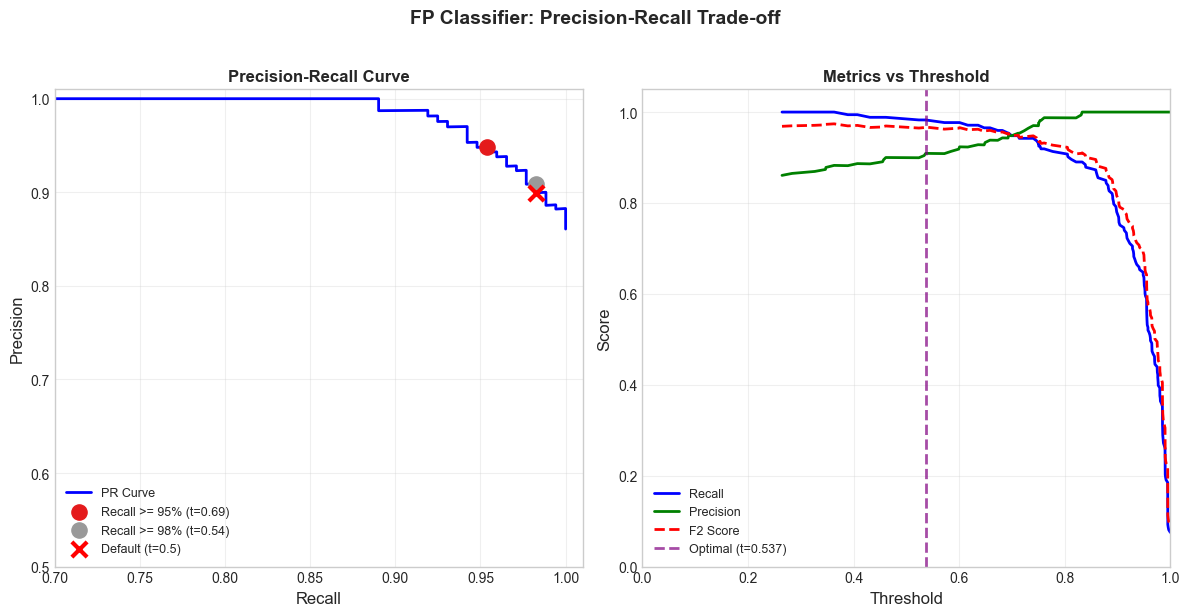

In [10]:
# Plot threshold analysis
fig = plot_threshold_analysis(
    y_test, y_proba,
    target_recalls=[0.95, 0.98],
    optimal_threshold=optimal_threshold,
    title='FP Classifier: Precision-Recall Trade-off',
    save_path='images/fp_threshold_tradeoff.png'
)

## 5. Export for Deployment

Create and save the complete pipeline (transformer + classifier) for Docker API deployment.

In [11]:
# Create deployment pipeline
full_pipeline = create_deployment_pipeline(
    transformer=transformer,
    classifier=best_model,
    pipeline_name='fp_classifier'
)

print(f"Created pipeline: {full_pipeline}")

Created pipeline: Pipeline(steps=[('features',
                 FPFeatureTransformer(method='sentence_transformer_ner', proximity_window_size=10)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_split=5, n_estimators=200,
                                        n_jobs=-1, random_state=42))])


In [12]:
# Prepare deployment configuration
deployment_config = {
    # Threshold settings
    'threshold': float(optimal_threshold),
    'target_recall': TARGET_RECALL,
    
    # Model info
    'model_name': cv_metrics['model_name'],
    'transformer_method': transformer.method,
    'best_params': cv_metrics['best_params'],
    
    # CV performance
    'cv_f2': cv_metrics['cv_f2'],
    'cv_recall': cv_metrics['cv_recall'],
    'cv_precision': cv_metrics['cv_precision'],
    
    # Test performance
    'test_f2': float(test_metrics['f2']),
    'test_recall': float(test_metrics['recall']),
    'test_precision': float(test_metrics['precision']),
    
    # Performance at threshold
    'threshold_recall': float(threshold_metrics['actual_recall']),
    'threshold_precision': float(threshold_metrics['precision']),
    'threshold_f2': float(threshold_metrics['f2_score']),
}

# Save deployment artifacts
saved_paths = save_deployment_artifacts(
    pipeline=full_pipeline,
    config=deployment_config,
    models_dir=MODELS_DIR,
    pipeline_name='fp_classifier'
)

Pipeline saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_pipeline.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_config.json


## 6. Pipeline Validation

Test the exported pipeline on sample texts to ensure it works correctly.

In [13]:
# Define sample texts for validation
validation_texts = [
    # True sportswear examples
    "Nike announces new sustainability initiative to reduce carbon emissions in manufacturing",
    "Adidas partners with Parley for the Oceans to create recycled plastic sneakers",
    "Under Armour CEO discusses quarterly earnings and growth strategy",
    
    # False positive examples (should be filtered)
    "Puma the wild cat was spotted in the mountains of Montana near hiking trails",
    "Patagonia region experiences record tourism as travelers explore natural wonders",
    "Black Diamond power company announces new renewable energy investments",
]

# Validate pipeline
validation_results = validate_pipeline(
    pipeline=full_pipeline,
    test_texts=validation_texts,
    threshold=optimal_threshold,
    verbose=True
)

In [14]:
print("=" * 60)
print("FP3 NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nBest Model: {cv_metrics['model_name']}")
print(f"Feature Method: {transformer.method}")
print(f"\nCV Performance:")
print(f"  F2 Score:  {cv_metrics['cv_f2']:.4f}")
print(f"  Recall:    {cv_metrics['cv_recall']:.4f}")
print(f"  Precision: {cv_metrics['cv_precision']:.4f}")
print(f"\nTest Set Performance:")
print(f"  F2 Score:  {test_metrics['f2']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"\nDeployment Settings:")
print(f"  Target Recall: {TARGET_RECALL:.0%}")
print(f"  Threshold:     {optimal_threshold:.4f}")
print(f"\nAt Deployment Threshold:")
print(f"  Recall:    {threshold_metrics['actual_recall']:.4f}")
print(f"  Precision: {threshold_metrics['precision']:.4f}")
print(f"  F2 Score:  {threshold_metrics['f2_score']:.4f}")
print(f"\nSaved Artifacts:")
for name, path in saved_paths.items():
    print(f"  - {path}")
print("=" * 60)

FP3 NOTEBOOK SUMMARY

Best Model: RF_tuned
Feature Method: sentence_transformer_ner

CV Performance:
  F2 Score:  0.9723
  Recall:    0.9957
  Precision: 0.8888

Test Set Performance:
  F2 Score:  0.9648
  Recall:    0.9827
  Precision: 0.8995

Deployment Settings:
  Target Recall: 98%
  Threshold:     0.5366

At Deployment Threshold:
  Recall:    0.9827
  Precision: 0.9091
  F2 Score:  0.9670

Saved Artifacts:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_pipeline.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_config.json


## Next Steps

1. **Deploy Model**: Integrate `fp_classifier_pipeline.joblib` into Docker API service
2. **Configure Threshold**: Use `fp_classifier_config.json` for threshold and settings
3. **Monitor Performance**: Track F2/recall on new data to detect drift
4. **Retrain Periodically**: Update model as more labeled data becomes available